In [1]:
import time
import torch
import tqdm
import torch.utils.data as data

from matplotlib import pyplot as plt
from statistics import mean
from torch import nn, optim
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, datasets
from PIL import Image

# Generator
* Output image size is 64 x 64.
* 4 CNN layers.
* In each CNN layers, Transpose Convolution is used.

## ConvTranspose2d parameters
* in_channel
* out_channel
* kernel_size
* stride
* padding

## How Transpose Convolution works.
* https://lhopital.hatenablog.com/entry/2020/10/24/081133#%E3%82%B9%E3%83%88%E3%83%A9%E3%82%A4%E3%83%89-1
* https://github.com/vdumoulin/conv_arithmetic

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

# Generator Operation Check
* input_z.shape: torch.Size([1, 20, 1, 1])
* layer1_output.shape: torch.Size([1, 512, 4, 4])
* layer2_output.shape: torch.Size([1, 256, 8, 8])
* layer3_output.shape: torch.Size([1, 128, 16, 16])
* layer4_output.shape: torch.Size([1, 64, 32, 32])
* last_output.shape: torch.Size([1, 1, 64, 64])

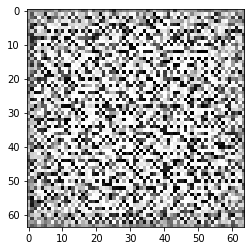

In [3]:
G = Generator(z_dim=20, image_size=64)
input_z = torch.randn(1, 20)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()

plt.imshow(img_transformed, cmap='gray')
plt.show()

# Discriminator
* Applys CNN layer 5 times, then applys sigmoid activation function.
* input.shape: torch.Size([1, 1, 64, 64])
* output.shape: torch.Size([1, 1, 1, 1])

In [4]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size * 2, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size * 4, image_size * 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.last = nn.Conv2d(image_size * 8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

# Descriminator Operation Check

In [5]:
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_image = G(input_z)

d_out = D(fake_image)

#print(nn.Sigmoid()(d_out))
print(nn.Sigmoid()(d_out))

tensor([[[[0.5029]]]], grad_fn=<SigmoidBackward>)


# Initialize Weight 

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (last): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

# Dataloader

In [7]:
def make_datapath_list():
    
    train_img_list = list()
    
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = "./data/img_78/img_8_" + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

In [8]:
class ImageTransform():
    
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img):
        return self.data_transform(img)

In [9]:
class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img)
        
        return img_transformed

In [10]:
train_img_list = make_datapath_list()

mean = (0.5),
std = (0.5),

train_dataset = GAN_Img_Dataset(
    file_list = train_img_list,
    transform = ImageTransform(mean, std)
    )

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
    )

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)
print(images.size())

torch.Size([64, 1, 64, 64])


In [11]:
def train_model(G, D, dataloader, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    z_dim = 20
    mini_batch_size  = 64
    
    D.to(device)
    G.to(device)
    
    D.train()
    G.train()
    
    torch.backends.cudnn.benchmark = True
    
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    iteration = 1
    logs = []
    
    d_loss_history = []
    g_loss_history = []
      
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        if epoch % 50 == 0:
            print('-------------')
            print('Epoch {}/{}'.format(epoch, num_epochs))
            print('-------------')
            print('（train）')

        for imges in dataloader:
            # pass batch_normalization error when batch_size == 1.
            if imges.size()[0] == 1:
                continue

            # train descriminator
            imges = imges.to(device)

            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            d_out_real = D(imges)

            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # train generator 
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            g_loss = criterion(d_out_fake.view(-1), label_real)

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        d_loss_history.append(d_loss.item())
        g_loss_history.append(g_loss.item())

        t_epoch_finish = time.time()
        if epoch % 50 == 0:
            print('-------------')
            print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
            print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
            t_epoch_start = time.time()

    return G, D, d_loss_history, g_loss_history

In [12]:
num_epochs  = 200
G_update, D_update , d_loss_history, g_loss_history = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

cuda:0
-------------
Epoch 0/200
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.2428
timer:  0.5325 sec.
-------------
Epoch 50/200
-------------
（train）
-------------
epoch 50 || Epoch_D_Loss:0.1147 ||Epoch_G_Loss:0.1312
timer:  0.2831 sec.
-------------
Epoch 100/200
-------------
（train）
-------------
epoch 100 || Epoch_D_Loss:0.0701 ||Epoch_G_Loss:0.2508
timer:  0.2859 sec.
-------------
Epoch 150/200
-------------
（train）
-------------
epoch 150 || Epoch_D_Loss:0.0642 ||Epoch_G_Loss:0.2949
timer:  0.2864 sec.


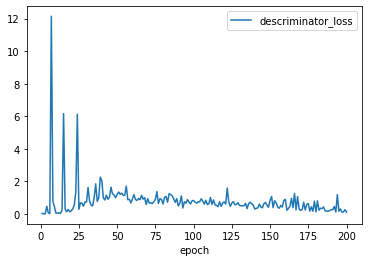

In [13]:
plt.figure()
plt.plot(range(1, num_epochs+1), d_loss_history, label='descriminator_loss')
plt.xlabel('epoch')
plt.legend()

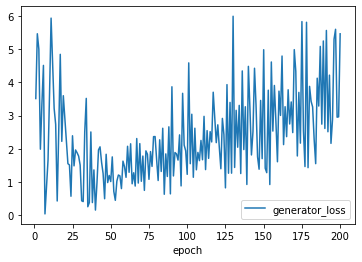

In [14]:
plt.figure()
plt.plot(range(1, num_epochs+1), g_loss_history, label='generator_loss')
plt.xlabel('epoch')
plt.legend()

# Visulalize Result
* If num_epochs > 200, generator makes only 7, which is easy to mislead descriminator.
* This is  the **Mode collapse** .

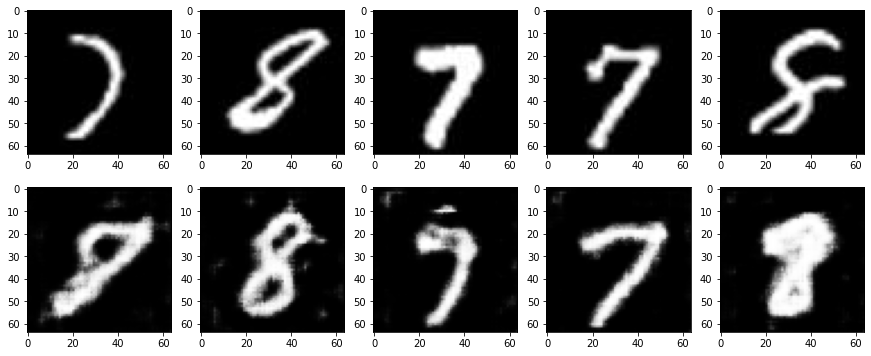

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Input random param
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

G_update.eval()
fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')